In [3]:
# Importing necessary libraries and modules
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import matplotlib.dates as dates

In [4]:
# Load data
countries = pd.read_csv("./data/village_savings/Countries.csv")
locations = pd.read_csv("./data/village_savings/Locations.csv")
regions = pd.read_csv("./data/village_savings/Regions.csv")
members = pd.read_csv("./data/village_savings/Members.csv") #tab seperated csv
group_members = pd.read_csv("./data/village_savings/GroupMembers.csv")
groups = pd.read_csv("./data/village_savings/SavingsGroups.csv")


In [5]:
groups.groupby([groups.IsActive]).GroupID.count()

IsActive
1    132
Name: GroupID, dtype: int64

In [6]:
# Join data: Location Name, Region Name, and Country Name
groups = groups.merge(locations, on="LocationId").merge(regions, on="RegionId").merge(countries, on="CountryCode")

In [7]:
# Get Member of groups
# groups[groups.GroupStatusCode != 'E']
groups['NumberOfMembers'] = 0
for idx, row in groups.iterrows():
   if row.IsKhusaServiceOffered == 1:
       groups.at[idx, 'NumberOfMembers'] = group_members[lambda x: x.GroupID == row.GroupID]['GroupID'].count()

In [8]:
# Create pivot table using RegionName and CountryName columns.
group_pivot_table = pd.pivot_table(groups[groups.NumberOfMembers > 0], values='NumberOfMembers', index=['RegionName', 'CountryName'], columns=['GroupName'], fill_value=0)

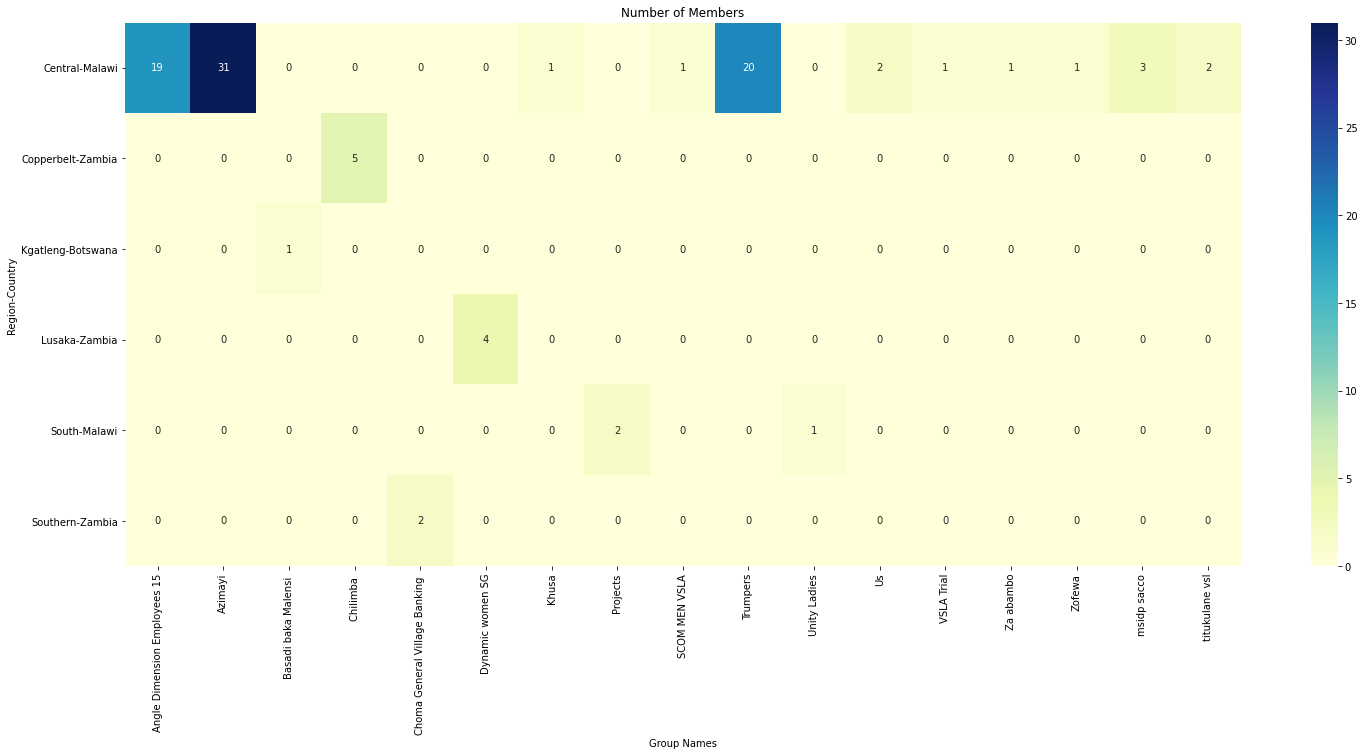

In [9]:
#Question 1. How many groups and members are there currently registered? And what is their geographical coverage? (Country and Region)
fig,ax = plt.subplots(figsize=(25, 10))
sns.heatmap(group_pivot_table, annot=True,ax=ax,cmap="YlGnBu", )
plt.ylabel('Region-Country')
plt.xlabel('Group Names')
plt.title("Number of Members")
plt.show()

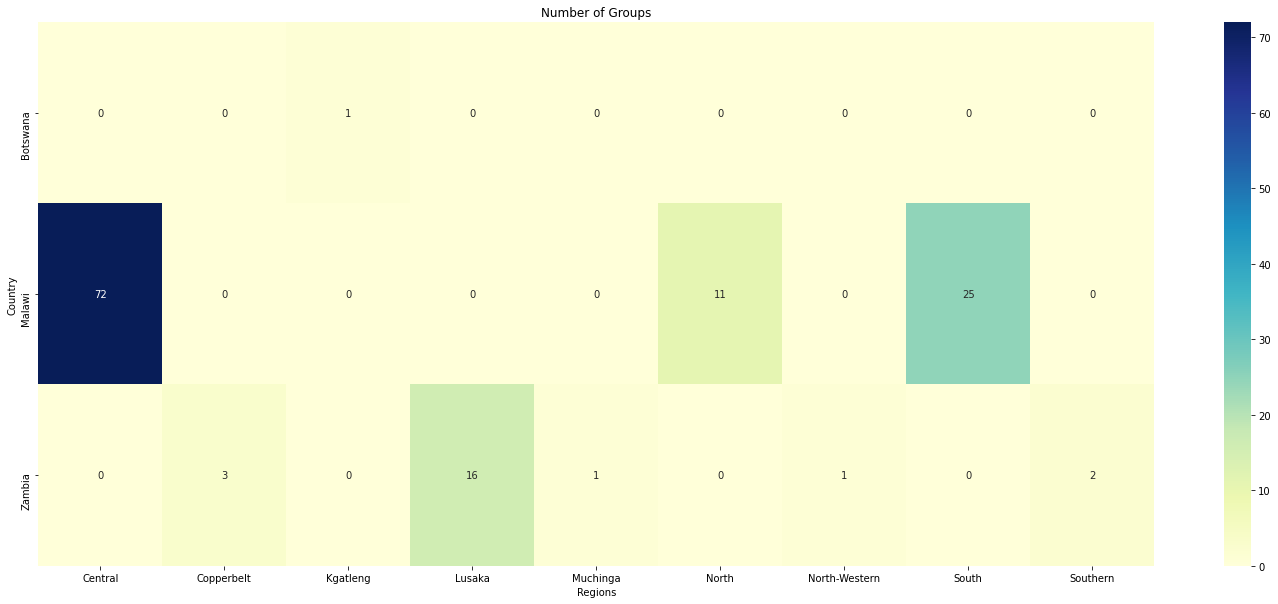

In [10]:
# Create pivot table using RegionName and CountryName columns.
group_counts = groups.groupby([groups.CountryName, groups.RegionName]).GroupID.count().reset_index()
group_count_pvt_table = pd.pivot_table(group_counts, values='GroupID', index=['CountryName'], columns=['RegionName'], fill_value=0)
fig,ax = plt.subplots(figsize=(25, 10))
sns.heatmap(group_count_pvt_table, annot=True,ax=ax,cmap="YlGnBu", )
plt.ylabel('Country')
plt.xlabel('Regions')
plt.title("Number of Groups")
plt.show()

<AxesSubplot:xlabel='LocationName'>

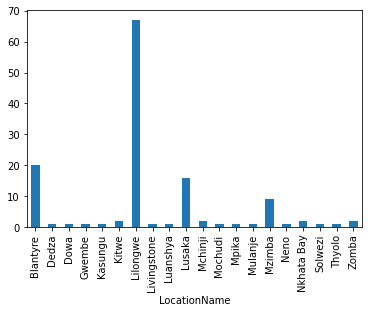

In [11]:
groups.groupby([groups.LocationName]).GroupID.count().plot.bar()

In [12]:
group_members = group_members.merge(members[['MemberID', 'Gender', 'DateOfBirth']], on="MemberID", how='left').merge(groups[['GroupID', 'GroupName', 'RegionName', 'LocationName']], on="GroupID" , how="right")

<AxesSubplot:title={'center':'Gender Distribution by Groups'}, ylabel='GroupName'>

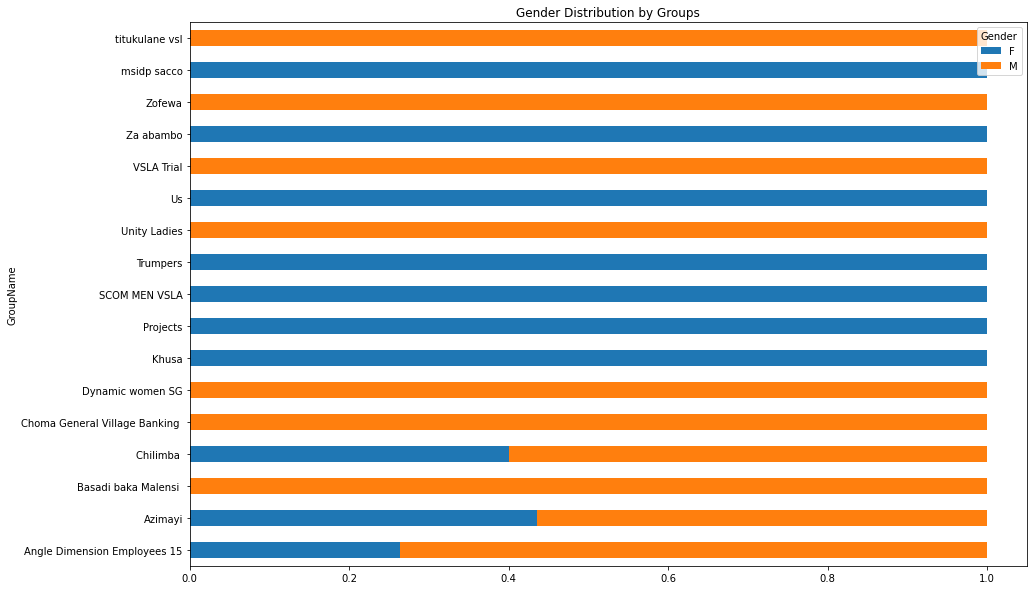

In [13]:
# pd.crosstab([group_members.GroupName],group_members.Gender).plot.bar()
group_members.dropna(subset=['Gender']).groupby(group_members.GroupName).Gender.value_counts(normalize=True).unstack().plot.barh(stacked=True, figsize=(15, 10), title="Gender Distribution by Groups")

<AxesSubplot:title={'center':'Gender Distribution by Groups'}, ylabel='RegionName'>

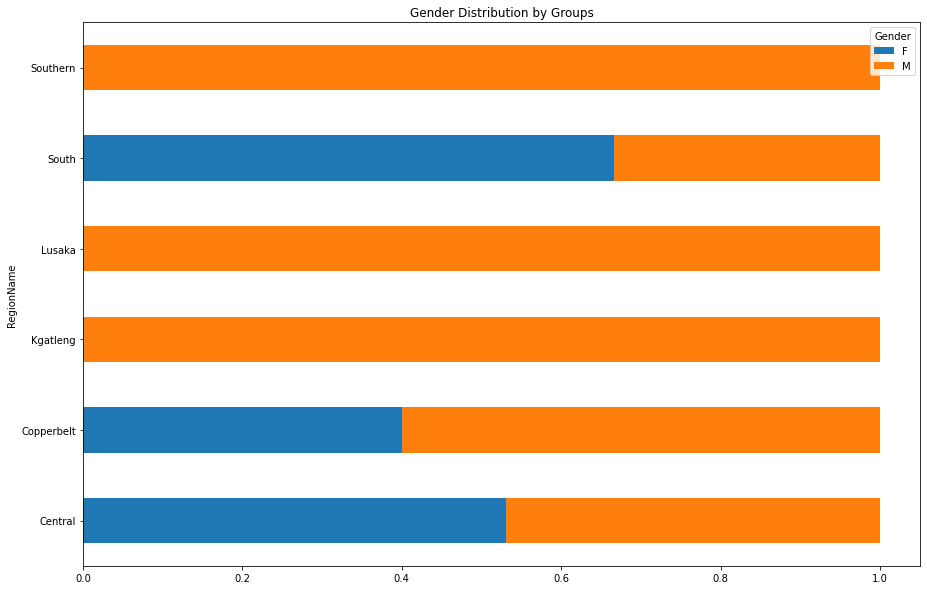

In [14]:
group_members.dropna(subset=['Gender']).groupby([group_members.RegionName]).Gender.value_counts(normalize=True).unstack().plot.barh(stacked=True, figsize=(15, 10), title="Gender Distribution by Groups")


[['Dowa', 1.0], ['Mchinji', 1.0], ['Kasungu', 1.0], ['Dedza', 1.0], ['Zomba', 1.0], ['Mulanje', 1.0], ['Thyolo', 1.0], ['Neno', 1.0], ['Mzimba', 1.0], ['Nkhata Bay', 1.0], ['Luanshya', 1.0], ['Gwembe', 1.0], ['Livingstone', 1.0], ['Lusaka', 1.0], ['Solwezi', 1.0], ['Mpika', 1.0], ['Mochudi', 1.0]]


Text(0, 0.5, 'Bias')

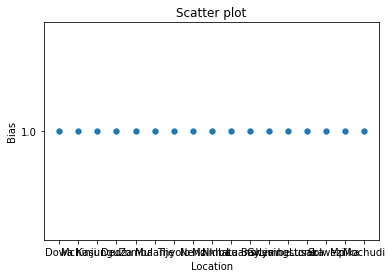

In [15]:
threshold = 0.4
location_names =  group_members.LocationName.unique()
gender_by_locations = group_members.groupby(group_members.LocationName).Gender.value_counts(normalize=True)
biased_locs=[]
for location in location_names:
    try:
        bias = abs(gender_by_locations.loc[location, 'F'] - gender_by_locations.loc[location, 'M'])
        if bias > threshold:
            biased_locs.append([location, round(bias, 2)])
    except KeyError:
        biased_locs.append([location, 1.0])
print(biased_locs)
biased_locs =  np.array(biased_locs)
plt.scatter(biased_locs[:, 0], biased_locs[:, 1], s=np.pi*9, vmin=0.0, vmax=1.0)
plt.title('Scatter plot')
plt.xlabel('Location')
plt.ylabel('Bias')

In [16]:
group_members.DateOfBirth = pd.to_datetime(group_members.DateOfBirth, format="%d-%m-%Y")
group_members['Age'] = datetime.datetime.now().year - group_members.DateOfBirth.dt.year
# group_members.fillna({'Age': 0}, inplace=True)
group_members

,MemberGroupID,MemberID,GroupID,IsMainMember,MemberStatusCode,DateCreated,Gender,DateOfBirth,GroupName,RegionName,LocationName,Age
0,1.0,1.0,1,1.0,A,24-09-18 15:20:10,M,1960-08-16,Angle Dimension Employees 15,Central,Lilongwe,61.0
1,2.0,2.0,1,1.0,A,24-09-18 16:04:23,M,1979-10-26,Angle Dimension Employees 15,Central,Lilongwe,42.0
2,3.0,3.0,1,1.0,A,24-09-18 16:06:17,M,1987-10-22,Angle Dimension Employees 15,Central,Lilongwe,34.0
3,4.0,4.0,1,1.0,A,24-09-18 16:08:07,M,1965-09-09,Angle Dimension Employees 15,Central,Lilongwe,56.0
4,5.0,5.0,1,1.0,A,24-09-18 16:10:24,M,1986-11-21,Angle Dimension Employees 15,Central,Lilongwe,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...
237,NaN,NaN,124,NaN,NaN,NaN,NaN,NaT,Evergreen,Lusaka,Lusaka,NaN
238,NaN,NaN,126,NaN,NaN,NaN,NaN,NaT,Power Save,Lusaka,Lusaka,NaN
239,NaN,NaN,56,NaN,NaN,NaN,NaN,NaT,Lunga Agro Cooperative Society Ltd,North-Western,Solwezi,NaN
240,NaN,NaN,88,NaN,NaN,NaN,NaN,NaT,Chitulika YLA,Muchinga,Mpika,NaN


In [17]:
group_members[group_members.Age > 0].groupby([group_members.GroupName]).Age.agg(['min', 'max', 'mean']).reset_index().rename(columns={'min': 'Lowest Age', 'max': 'Highest Age', 'mean': 'Average'})


,GroupName,Lowest Age,Highest Age,Average
0,Angle Dimension Employees 15,4.0,61.0,34.894737
1,Azimayi,2.0,31.0,4.080645
2,Basadi baka Malensi,34.0,34.0,34.000000
3,Chilimba,26.0,61.0,36.600000
4,Choma General Village Banking,37.0,39.0,38.000000
5,Dynamic women SG,38.0,50.0,46.250000
6,Khusa,34.0,34.0,34.000000
7,Projects,30.0,30.0,30.000000
8,SCOM MEN VSLA,35.0,35.0,35.000000
9,Trumpers,23.0,40.0,32.500000


In [18]:
group_members[group_members.Age > 0].groupby([group_members.RegionName]).Age.agg(['min', 'max', 'mean']).reset_index().rename(columns={'min': 'Lowest Age'})


,RegionName,Lowest Age,max,mean
0,Central,2.0,61.0,16.486726
1,Copperbelt,26.0,61.0,36.600000
2,Kgatleng,34.0,34.0,34.000000
3,Lusaka,38.0,50.0,46.250000
4,South,30.0,30.0,30.000000
5,Southern,37.0,39.0,38.000000


In [19]:
age_groups = pd.qcut(group_members[group_members.Age > 0].Age, 4, duplicates='drop', labels=["Below 21", "Between 21 and 32", "Above 32"])

group_members[group_members.Age > 0].groupby([group_members.RegionName, age_groups, group_members.Gender]).Age.count()



RegionName  Age                Gender
Central     Below 21           F         29
                               M         39
            Between 21 and 32  F         20
                               M          4
            Above 32           F         11
                               M         10
Copperbelt  Below 21           F          0
                               M          0
            Between 21 and 32  F          2
                               M          1
            Above 32           F          0
                               M          2
Kgatleng    Below 21           F          0
                               M          0
            Between 21 and 32  F          0
                               M          0
            Above 32           F          0
                               M          1
Lusaka      Below 21           F          0
                               M          0
            Between 21 and 32  F          0
                               M      

<ipython-input-20-8aea294f7e16>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  groups[groups.CountryName == 'Malawi'][groups.LocationName.isin(major_cities)].groupby(['LocationName']).NumberOfMembers.count().plot.pie(subplots=True, figsize=(10,10), autopct='%1.1f%%', legend=True, title="Coverage of Members in Major Cities")


array([<AxesSubplot:ylabel='NumberOfMembers'>], dtype=object)

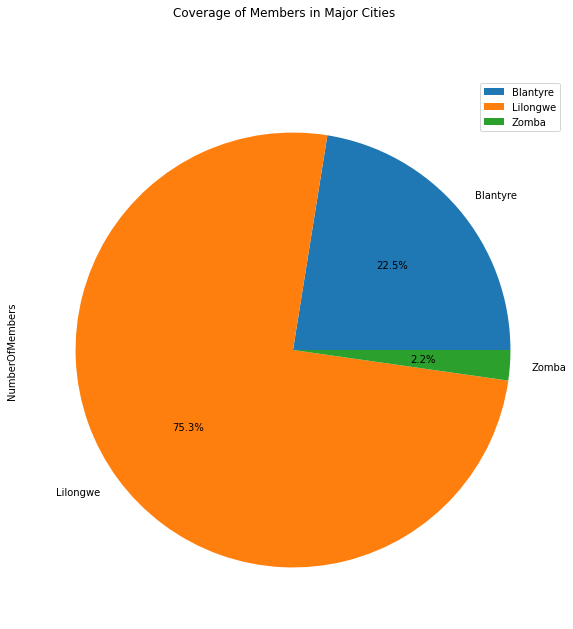

In [20]:
major_cities = ['Lilongwe', 'Zomba', 'Mzuzu', 'Blantyre'] #major cities in Malawi
groups[groups.CountryName == 'Malawi'][groups.LocationName.isin(major_cities)].groupby(['LocationName']).NumberOfMembers.count().plot.pie(subplots=True, figsize=(10,10), autopct='%1.1f%%', legend=True, title="Coverage of Members in Major Cities")

In [21]:
group_members.DateCreated = pd.to_datetime(group_members.DateCreated, format="%d-%m-%y %H:%M:%S")
groups.DateCreated = pd.to_datetime(groups.DateCreated, format="%d-%m-%y %H:%M:%S")



Text(0.5, 1.0, 'Annual Group and Member growth')

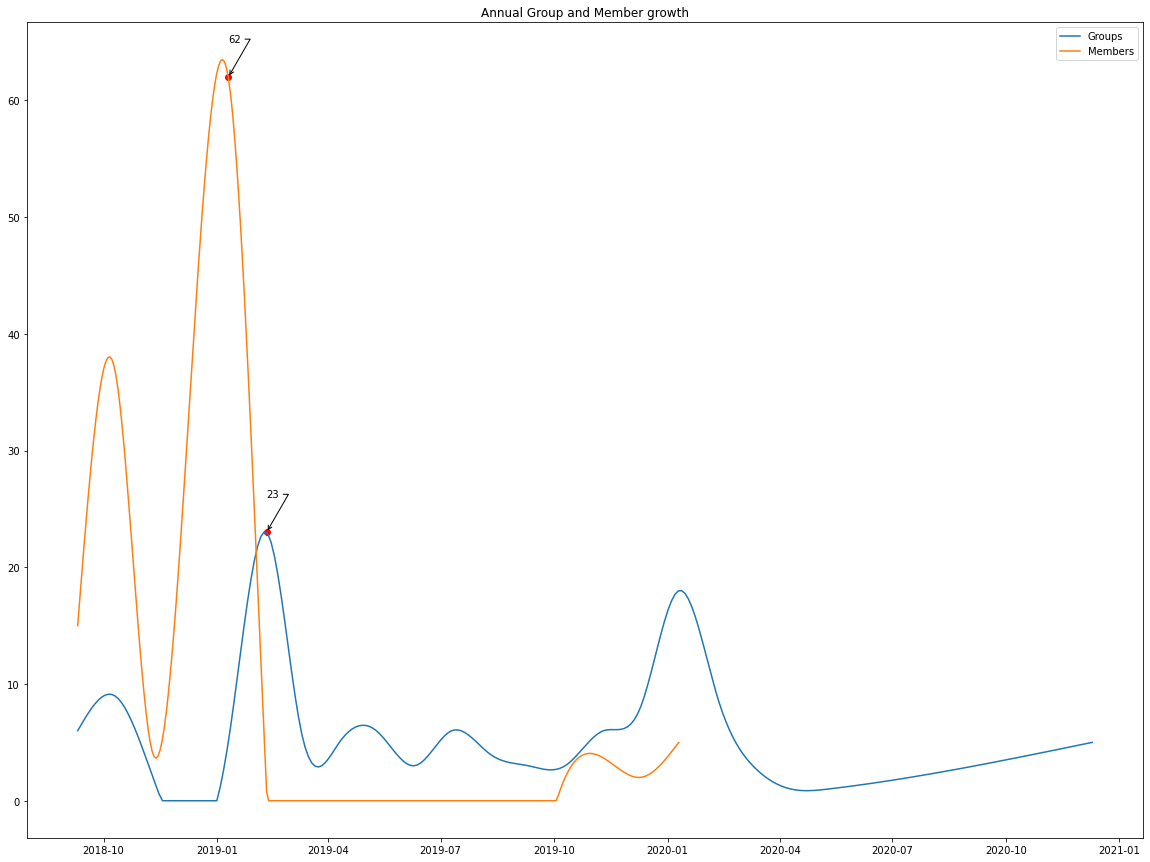

In [201]:
groups['Period'] = groups.DateCreated.dt.strftime("%b-%Y")
group_members['Period'] = group_members.DateCreated.dt.strftime("%b-%Y")
member_annual_data = group_members.groupby([group_members.Period]).MemberID.count().reset_index().rename(columns={'MemberID': 'Count'})
annaul_group_data = groups.groupby([groups.Period]).GroupID.count().reset_index().rename(columns={'GroupID': 'Count'})

data = [annaul_group_data, member_annual_data]
labels = ['Groups', 'Members']
member_annual_data.sort_values(by="Period", key=lambda x: dates.datestr2num(x), inplace=True)
annaul_group_data.sort_values(by="Period", key=lambda x: dates.datestr2num(x), inplace=True)
fig, ax = plt.subplots(figsize=(20, 15))
for i in range(len(data)):
    period = dates.datestr2num(data[i].Period.to_numpy())
    smooth_x = np.linspace(period.min(), period.max(), 300)
    sline = make_interp_spline(period, data[i].Count.to_numpy(), k=3, bc_type='natural')
    interp_values = sline(smooth_x).clip(0, max(sline(smooth_x)))
    max_index = data[i].Count.idxmax()
    max_period = dates.datestr2num(data[i].loc[max_index].Period)
    max_count = data[i].loc[max_index].Count

    ax.plot(dates.num2date(max_period),max_count, 'ro')
    ax.annotate('{0}'.format(max_count), xy=(dates.num2date(max_period), max_count), xytext=(dates.num2date(max_period), max_count + 3), arrowprops=dict(arrowstyle='->', connectionstyle="angle,angleA=0,angleB=60"))
    ax.plot(dates.num2date(smooth_x), interp_values, label=labels[i])
    ax.legend(loc="upper right")

plt.title("Annual Group and Member growth")